In [ ]:
# Calculating Chatgpt next token probability

In [ ]:
!pip install  --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.8/999.8 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.109.1
    Uninstalling openai-1.109.1:
      Successfully uninstalled openai-1.109.1


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


Top 10 predicted tokens:
' to': 41.348%
' through': 10.832%
' far': 6.063%
' back': 4.677%
' a': 4.049%
' the': 2.707%
' out': 2.439%
' from': 2.417%
' where': 1.796%
' on': 1.438%


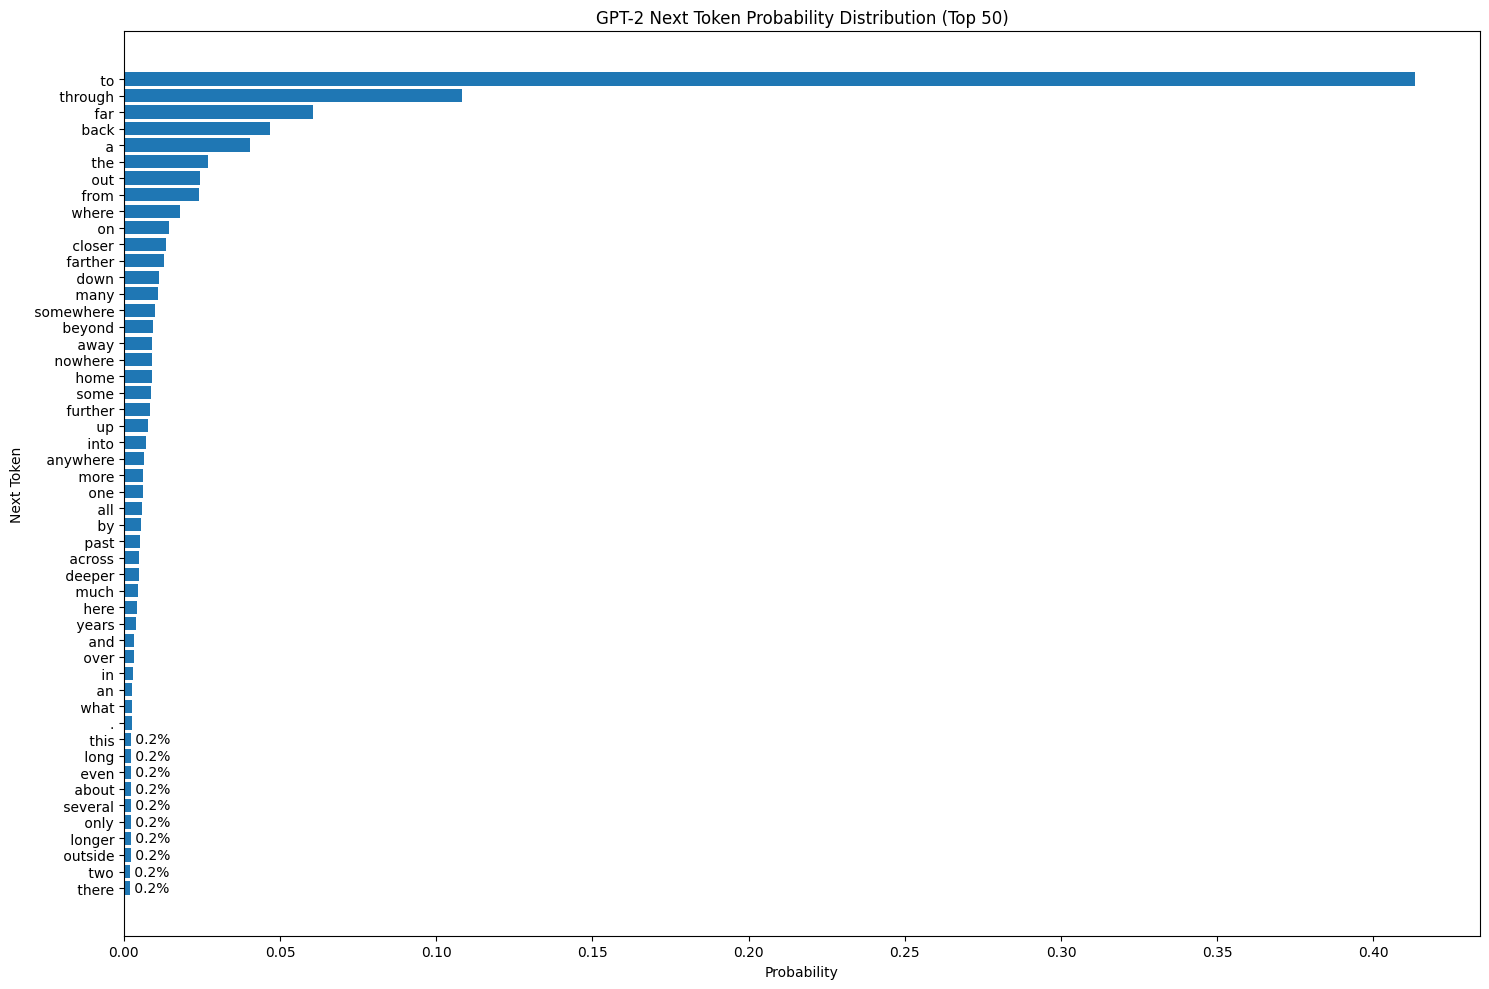

In [ ]:
!pip install torch transformers matplotlib --quiet
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import matplotlib.pyplot as plt
import numpy as np

# Load model & tokenizer from Hugging Face
model_name = "gpt2"   # or "gpt2-medium", "gpt2-large" for bigger models
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

# Input sentence
sentence = "After years of hard work, your effort will take you"

# Tokenize input
inputs = tokenizer(sentence, return_tensors="pt")

# Get model output (logits)
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Get logits for next token prediction (last position)
next_token_logits = logits[0, -1, :]

# Convert logits to probabilities
probs = torch.softmax(next_token_logits, dim=-1)

# Convert to numpy for visualization
probs_np = probs.cpu().numpy()

# Get top 50 tokens
top_k = 50
top_probs, top_indices = torch.topk(probs, top_k)
top_tokens = [tokenizer.decode([idx]) for idx in top_indices]

# Normalize for readability
top_probs_np = top_probs.cpu().numpy()
top_probs_np /= top_probs_np.sum()

# Display top 10 tokens with probabilities
print("\nTop 10 predicted tokens:")
for token, prob in zip(top_tokens[:10], top_probs_np[:10]):
    print(f"'{token}': {prob:.3%}")

# Plot probabilities
plt.figure(figsize=(15, 10))
plt.barh(range(top_k), top_probs_np[::-1])
plt.yticks(range(top_k), [t.replace("\n", "\\n") for t in top_tokens[::-1]])
plt.xlabel('Probability')
plt.ylabel('Next Token')
plt.title(f'GPT-2 Next Token Probability Distribution (Top {top_k})')

# Add percentage labels for top tokens
for i, prob in enumerate(top_probs_np[::-1][:10]):
    plt.text(prob, i, f' {prob:.1%}', va='center')

plt.tight_layout()
plt.show()



In [ ]:
!pip install transformers torch --quiet

from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM

# Choose a model appropriate for your runtime (use a small one on CPU)
model_name = "gpt2"  # or an instruct model if available

# Create pipeline (tokenizer/model are loaded internally by pipeline)
generator = pipeline(
    "text-generation",
    model=model_name,
    device=-1  # set 0 if you have a GPU; set -1 for CPU
)

zero_shot_prompt = """
Classify the following bug report into one of these severity levels:
P0 (Critical), P1 (High), P2 (Medium), P3 (Low)

Bug report: {bug}

Provide only the severity level as response (P0, P1, P2, or P3).
"""

few_shot_prompt = """
Here are examples of bug reports and their severity classifications:

Bug: "Service completely down for all users"
Severity: P0 (Critical - immediate fix needed, affects all users, core functionality broken)

Bug: "Payment processing fails intermittently"
Severity: P1 (High - urgent fix needed, affects revenue, has workaround)

Bug: "Search results are slow to load"
Severity: P2 (Medium - should be fixed soon, affects user experience but not blocking)

Bug: "Wrong icon color in dark mode"
Severity: P3 (Low - minor issue, can be fixed in future release)

Now classify this bug report with one of these severity levels (P0, P1, P2, or P3):
Bug: {bug}

Provide only the severity level as response (P0, P1, P2, or P3).
"""

bug_reports = [
    "App crashes when uploading files larger than 2GB",
    "Font color is slightly different on the settings page",
    "Users can't log in during peak hours",
    "Tooltip shows wrong keyboard shortcut",
    "Rare data corruption occurs, leading to data loss in some edge cases",
    "Push notifications are delayed by up to 2 minutes",
    "Backend service occasionally times out during payment processing",
    "User profile pictures sometimes fail to load on the dashboard",
    "Server memory leak causes performance degradation over time",
    "Mobile app uses excessive battery when the GPS is on"
]

def extract_label_from_generated_text(generated_text):
    """
    Heuristic to extract the single label (P0/P1/P2/P3) from generated text.
    Returns the first occurrence of P0/P1/P2/P3 or the stripped last token line.
    """
    for label in ["P0", "P1", "P2", "P3"]:
        if label in generated_text:
            return label
    # fallback: take the last non-empty token-ish chunk
    tokens = [t.strip() for t in generated_text.splitlines() if t.strip()]
    if tokens:
        last = tokens[-1].split()[-1]
        return last
    return generated_text.strip()

print("Comparing Zero-shot vs Few-shot Learning for Bug Severity Classification:\n")

for bug in bug_reports:
    print(f"Bug Report: {bug}")

    # Zero-shot: deterministic/greeedy generation -> do_sample=False
    zero_prompt = zero_shot_prompt.format(bug=bug)
    zero_out = generator(zero_prompt, max_new_tokens=8, do_sample=False, pad_token_id=50256)[0]["generated_text"]
    zero_result = extract_label_from_generated_text(zero_out)
    print(f"Zero-shot classification: {zero_result}")

    # Few-shot: deterministic/greeedy generation -> do_sample=False
    few_prompt = few_shot_prompt.format(bug=bug)
    few_out = generator(few_prompt, max_new_tokens=8, do_sample=False, pad_token_id=50256)[0]["generated_text"]
    few_result = extract_label_from_generated_text(few_out)
    print(f"Few-shot classification: {few_result}\n")



Device set to use cpu
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Comparing Zero-shot vs Few-shot Learning for Bug Severity Classification:

Bug Report: App crashes when uploading files larger than 2GB
Zero-shot classification: P0
Few-shot classification: P0

Bug Report: Font color is slightly different on the settings page
Zero-shot classification: P0
Few-shot classification: P0

Bug Report: Users can't log in during peak hours
Zero-shot classification: P0
Few-shot classification: P0

Bug Report: Tooltip shows wrong keyboard shortcut
Zero-shot classification: P0
Few-shot classification: P0

Bug Report: Rare data corruption occurs, leading to data loss in some edge cases
Zero-shot classification: P0
Few-shot classification: P0

Bug Report: Push notifications are delayed by up to 2 minutes
Zero-shot classification: P0
Few-shot classification: P0

Bug Report: Backend service occasionally times out during payment processing
Zero-shot classification: P0
Few-shot classification: P0

Bug Report: User profile pictures sometimes fail to load on the dashboard

In [ ]:
from transformers import pipeline

# Initialize the text-generation pipeline
# You can use any small model to test, e.g., "google/flan-t5-base" or "facebook/bart-large"
generator = pipeline("text-generation", model="facebook/bart-large", device_map="auto")

# Define bug reports
bug_reports = [
    "App crashes when uploading files larger than 2GB",
    "Font color is slightly different on the settings page",
    "Users can't log in during peak hours",
    "Tooltip shows wrong keyboard shortcut",
    "Rare data corruption occurs, leading to data loss in some edge cases",
    "Push notifications are delayed by up to 2 minutes",
    "Backend service occasionally times out during payment processing",
    "User profile pictures sometimes fail to load on the dashboard",
    "Server memory leak causes performance degradation over time",
    "Mobile app uses excessive battery when the GPS is on"
]

# Zero-shot prompt
zero_shot_prompt = """
Classify the following bug report into one of these severity levels:
P0 (Critical), P1 (High), P2 (Medium), P3 (Low)

Bug report: {bug}

Provide only the severity level as response (P0, P1, P2, or P3).
"""

# Few-shot prompt
few_shot_prompt = """
Here are examples of bug reports and their severity classifications:

Bug: "Service completely down for all users"
Severity: P0 (Critical - immediate fix needed, affects all users, core functionality broken)

Bug: "Payment processing fails intermittently"
Severity: P1 (High - urgent fix needed, affects revenue, has workaround)

Bug: "Search results are slow to load"
Severity: P2 (Medium - should be fixed soon, affects user experience but not blocking)

Bug: "Wrong icon color in dark mode"
Severity: P3 (Low - minor issue, can be fixed in future release)

Now classify this bug report with one of these severity levels (P0, P1, P2, or P3):
Bug: {bug}

Provide only the severity level as response (P0, P1, P2, or P3).
"""

print("Comparing Zero-shot vs Few-shot Learning for Bug Severity Classification:\n")

for bug in bug_reports:
    print(f"Bug Report: {bug}")

    # --- Zero-shot classification ---
    zero_prompt = zero_shot_prompt.format(bug=bug)
    zero_output = generator(
        zero_prompt,
        max_new_tokens=20,
        temperature=0.3  # must be > 0
    )[0]["generated_text"]
    zero_result = zero_output.split("Provide only the severity level as response")[-1].strip()
    print(f"Zero-shot classification: {zero_result}")

    # --- Few-shot classification ---
    few_prompt = few_shot_prompt.format(bug=bug)
    few_output = generator(
        few_prompt,
        max_new_tokens=20,
        temperature=0.3
    )[0]["generated_text"]
    few_result = few_output.split("Provide only the severity level as response")[-1].strip()
    print(f"Few-shot classification: {few_result}\n")


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Comparing Zero-shot vs Few-shot Learning for Bug Severity Classification:

Bug Report: App crashes when uploading files larger than 2GB
Zero-shot classification: (P0, P1, P2, or P3).
 had had hadbe had hadma had had She had hadB had had- had had only
Few-shot classification: (P0, P1, P2, or P3).
 Flame FlameVE Flame Flame Flame simply Flame Flame flame Flame Flame Woman Flame Flameena Flame FlameWE

Bug Report: Font color is slightly different on the settings page
Zero-shot classification: (P0, P1, P2, or P3).
 had had hadbe had had Money had hadma had had actually had hadI had had only
Few-shot classification: (P0, P1, P2, or P3).
 Flame Flame FlameVE Flame Flame simply Flame Flame flame Flame Flame just Flame Flameena Flame FlameWE

Bug Report: Users can't log in during peak hours
Zero-shot classification: (P0, P1, P2, or P3).
 had had hadbe had had just had had Money had had actually had hadma had hadB
Few-shot classification: (P0, P1, P2, or P3).
 Flame FlameVE Flame Flame Flame Wo